In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

# Modeling and analysis of total electricity consumption (Estonia)

## Data source

https://dashboard.elering.ee/et/system/with-plan/production-consumption

## Read the data

In [2]:
el2022 = pd.read_csv('data/electricity-production and consumption_2022.csv',  delimiter=';',decimal=',')
el2022['timestamp'] = pd.to_datetime(el2022['Kuupaev (Eesti aeg)'], dayfirst=True)

consumption = el2022[['timestamp', 'Tarbimine']]
consumption.set_index('timestamp', inplace=True)
consumption = consumption.rename(columns = {'Tarbimine':'value'})

consumption.head()

,value
timestamp,
2022-01-01 00:00:00,899.4
2022-01-01 01:00:00,892.1
2022-01-01 02:00:00,874.3
2022-01-01 03:00:00,860.1
2022-01-01 04:00:00,842.7


In [3]:
planned_consumption = el2022[['timestamp', 'Planeeritud tarbimine']]
planned_consumption.set_index('timestamp', inplace=True)
planned_consumption = planned_consumption.rename(columns = {'Planeeritud tarbimine':'value'})
planned_consumption.head()

,value
timestamp,
2022-01-01 00:00:00,903.1
2022-01-01 01:00:00,935.8
2022-01-01 02:00:00,897.6
2022-01-01 03:00:00,878.5
2022-01-01 04:00:00,891.1


# 'Planeeritud tarbimine' vs. 'Tarbimine'

Let's compare planned ('Planeeritud') and actual ('Tarbimine') electricity consumption data.  
We use MAPE statistical metric.

In [34]:
#help(mean_absolute_percentage_error)

### Annual comparison

In [5]:
mape22 = mean_absolute_percentage_error(consumption, planned_consumption)*100


In [6]:
print("MAPE for 2022: %.3f" % mape22)

MAPE for 2022: 6.174


# It is all about looking for patterns!

## Two consecutive days reveal similarity

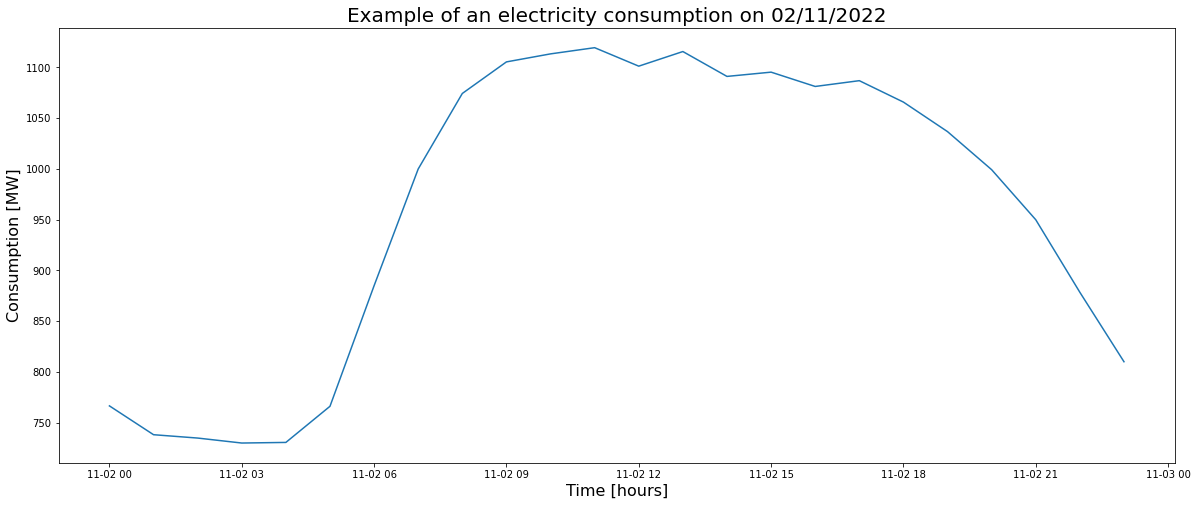

In [7]:
selection = consumption[(consumption.index >= datetime.datetime(2022, 11, 2)) 
                        &  (consumption.index < datetime.datetime(2022, 11, 3))]

plt.figure(figsize=(20,8))
plt.title("Example of an electricity consumption on 02/11/2022", fontsize = 20)
p = sns.lineplot(data = selection['value']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

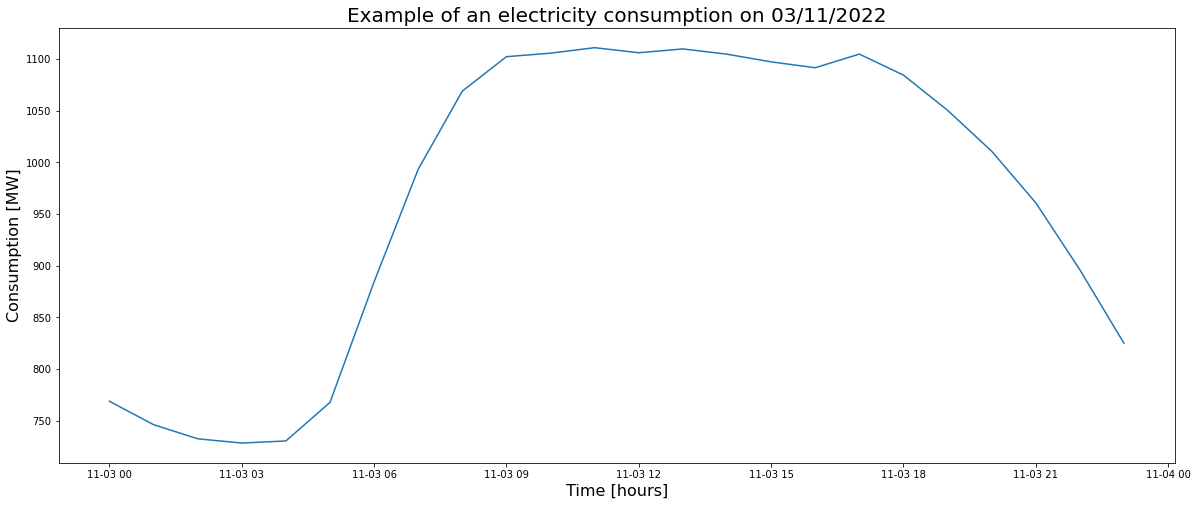

In [8]:
selection = consumption[(consumption.index >= datetime.datetime(2022, 11, 3)) 
                        &  (consumption.index < datetime.datetime(2022, 11, 4))]

plt.figure(figsize=(20,8))
plt.title("Example of an electricity consumption on 03/11/2022", fontsize = 20)
p = sns.lineplot(data = selection['value']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

## Two consecutive weeks

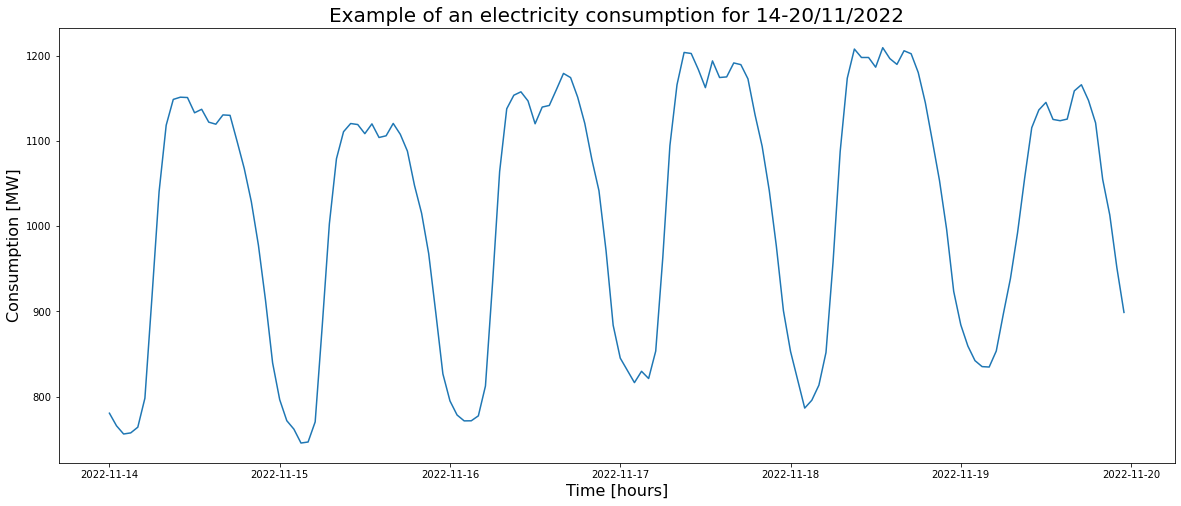

In [9]:
selection = consumption[(consumption.index >= datetime.datetime(2022, 11, 14)) 
                        &  (consumption.index < datetime.datetime(2022, 11, 20))]

plt.figure(figsize=(20,8))
plt.title("Example of an electricity consumption for 14-20/11/2022", fontsize = 20)
p = sns.lineplot(data = selection['value']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

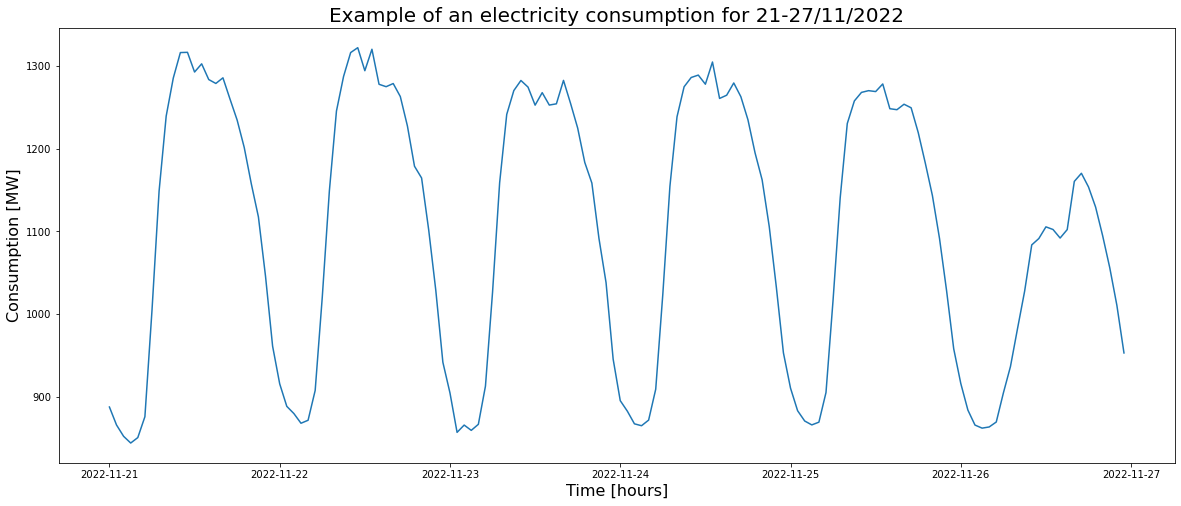

In [10]:
selection = consumption[(consumption.index >= datetime.datetime(2022, 11, 21)) 
                        &  (consumption.index < datetime.datetime(2022, 11, 27))]

plt.figure(figsize=(20,8))
plt.title("Example of an electricity consumption for 21-27/11/2022", fontsize = 20)
p = sns.lineplot(data = selection['value']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

# What can ruin the patterns?

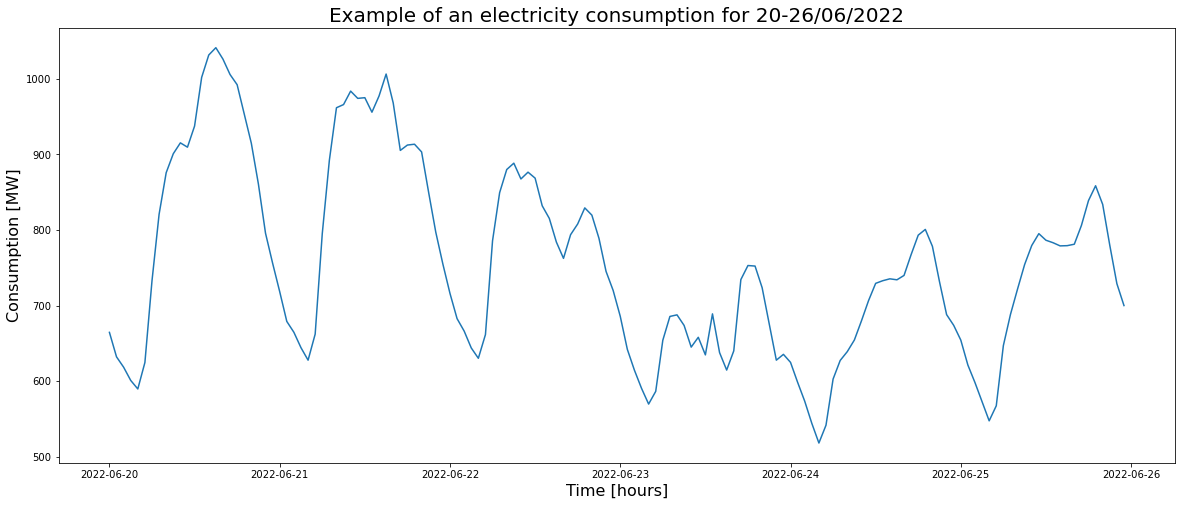

In [11]:
start_date = datetime.datetime(2022, 6,20)
end_date = datetime.datetime(2022, 6, 26)

selection = consumption[(consumption.index >= start_date) &  (consumption.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Example of an electricity consumption for 20-26/06/2022", fontsize = 20)
p = sns.lineplot(data = selection['value']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

# Features

In [12]:
# Actual consumption
consumption = el2022[['timestamp', 'Tarbimine']]
consumption.set_index('timestamp', inplace=True)
consumption = consumption.rename(columns = {'Tarbimine':'value'})

# lag7 is the data 7 days ago
consumption_lag7 = consumption[['value']].shift(24*7)
consumption_lag7 = consumption_lag7.rename(columns = {'value':'lag7'})
consumption = consumption.join(consumption_lag7)

# lag2 is the data 2 days ago
consumption_lag2 = consumption[['value']].shift(24*2)
consumption_lag2 = consumption_lag2.rename(columns = {'value':'lag2'})
consumption = consumption.join(consumption_lag2)

# Planned consumption
planned_consumption = el2022[['timestamp', 'Planeeritud tarbimine']]
planned_consumption.set_index('timestamp', inplace=True)
planned_consumption = planned_consumption.rename(columns = {'Planeeritud tarbimine':'planned'})
consumption = consumption.join(planned_consumption)

## External features

### Calendar based

### Temperature

https://rp5.ru/Weather_archive_in_Tallinn_(airport)

In [13]:
raw_weather = pd.read_csv('data/weather_2022.csv',  delimiter=';', decimal='.', index_col = False)
raw_weather['timestamp'] = pd.to_datetime(raw_weather['Local time in Tallinn (airport)'], dayfirst=True)
temperature = raw_weather[['timestamp', 'T']]
temperature.set_index('timestamp', inplace=True)


In [14]:
consumption = consumption.join(temperature)

In [15]:
consumption

,value,lag7,lag2,planned,T
timestamp,,,,,
2022-01-01 00:00:00,899.4,NaN,NaN,903.1,-1.0
2022-01-01 01:00:00,892.1,NaN,NaN,935.8,-0.6
2022-01-01 02:00:00,874.3,NaN,NaN,897.6,0.0
2022-01-01 03:00:00,860.1,NaN,NaN,878.5,-0.1
2022-01-01 04:00:00,842.7,NaN,NaN,891.1,-0.1
...,...,...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1,983.3,5.4
2022-12-31 20:00:00,932.5,982.7,1077.0,957.5,5.7
2022-12-31 21:00:00,889.5,965.4,1031.4,921.1,5.8


In [16]:
consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   value    8761 non-null   float64
 1   lag7     8593 non-null   float64
 2   lag2     8713 non-null   float64
 3   planned  8761 non-null   float64
 4   T        8732 non-null   float64
dtypes: float64(5)
memory usage: 410.7 KB


In [17]:
consumption['T'].fillna(method='bfill', inplace=True)
consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   value    8761 non-null   float64
 1   lag7     8593 non-null   float64
 2   lag2     8713 non-null   float64
 3   planned  8761 non-null   float64
 4   T        8761 non-null   float64
dtypes: float64(5)
memory usage: 410.7 KB


# Modeling

## Training/testing data split

In [18]:
predict_for_start = datetime.datetime(2022,11,4)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)

training_end = predict_for_start - datetime.timedelta(days = 1)
training_start = training_end - datetime.timedelta(days = 30)

testing_vector = consumption[(consumption.index >= predict_for_start) &  (consumption.index < predict_for_end)]
training_vector = consumption[(consumption.index >= training_start) &  (consumption.index < training_end)]

## Initial comparison: planned vs actual

MAPE: 2.418


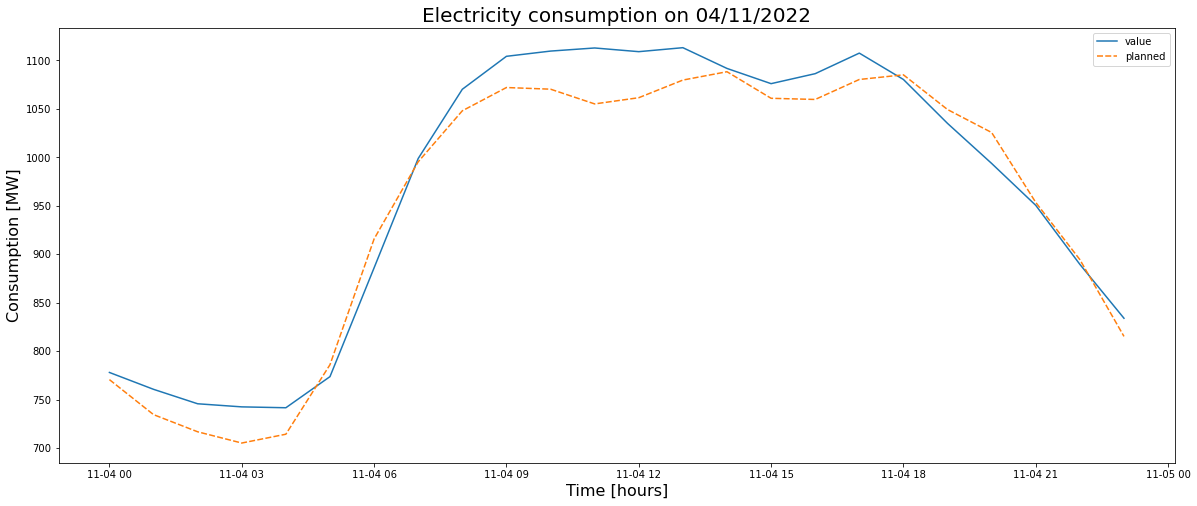

In [19]:
plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = testing_vector[['value','planned']]);
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(testing_vector['value'], testing_vector['planned'])*100))

 Let's try to improve it, or, at least achieve the same

## Naive model: lag7 as prediction
We just take the same day a week ago and compare them

MAPE: 1.552


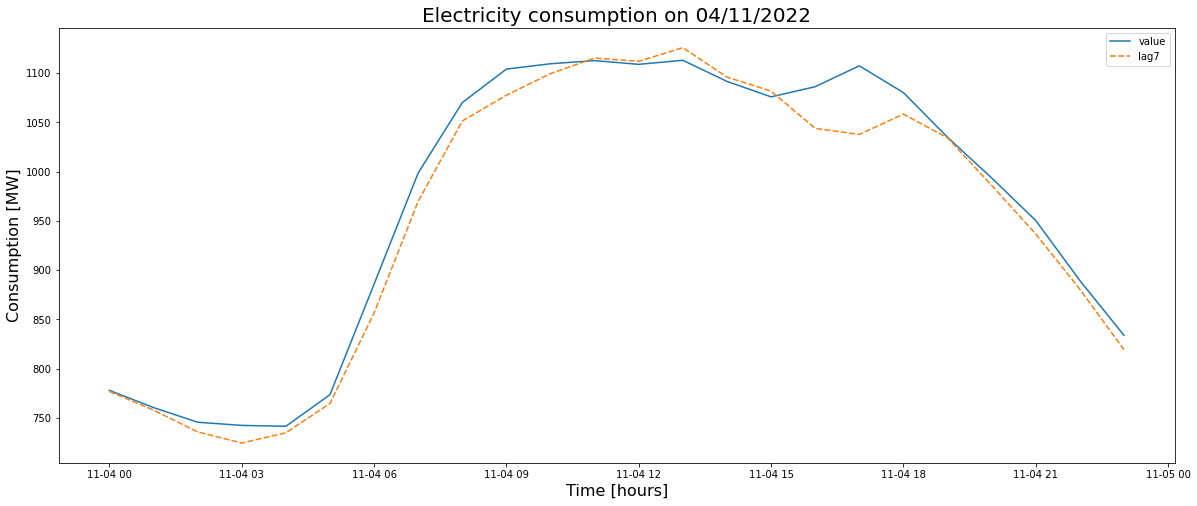

In [20]:
plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = testing_vector[['value','lag7']]);
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(testing_vector['value'], testing_vector['lag7'])*100))

## Linear regression
Let's make it a bit more sophisticated

### A single feature: lag7

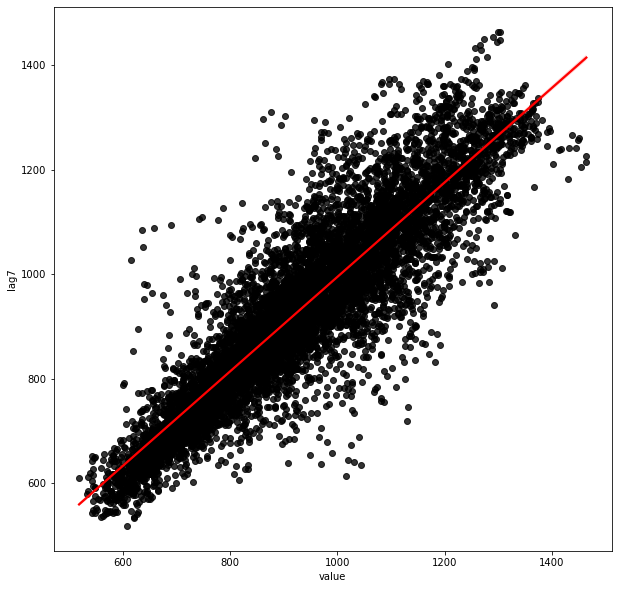

In [21]:
plt.figure(figsize=(10,10))
sns.regplot(x='value',y='lag7',data=consumption,  scatter_kws={"color": "black"}, line_kws={"color": "red"});

### There is a correlation. Let's try to model it

In [22]:
X_test = testing_vector[['lag7']]
y_test = testing_vector[['value']]

X_train = training_vector[['lag7']]
y_train = training_vector[['value']]

MAPE: 1.794


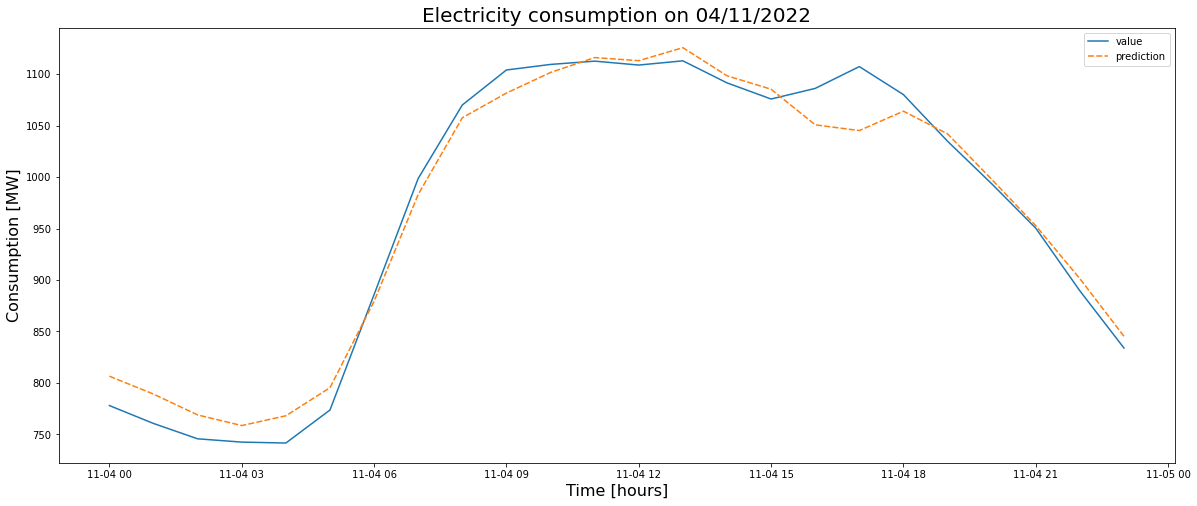

In [23]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

### Features: lag7 and lag2

In [24]:
X_test = testing_vector[['lag7', 'lag2']]
y_test = testing_vector[['value']]

X_train = training_vector[['lag7', 'lag2']]
y_train = training_vector[['value']]

MAPE: 1.352


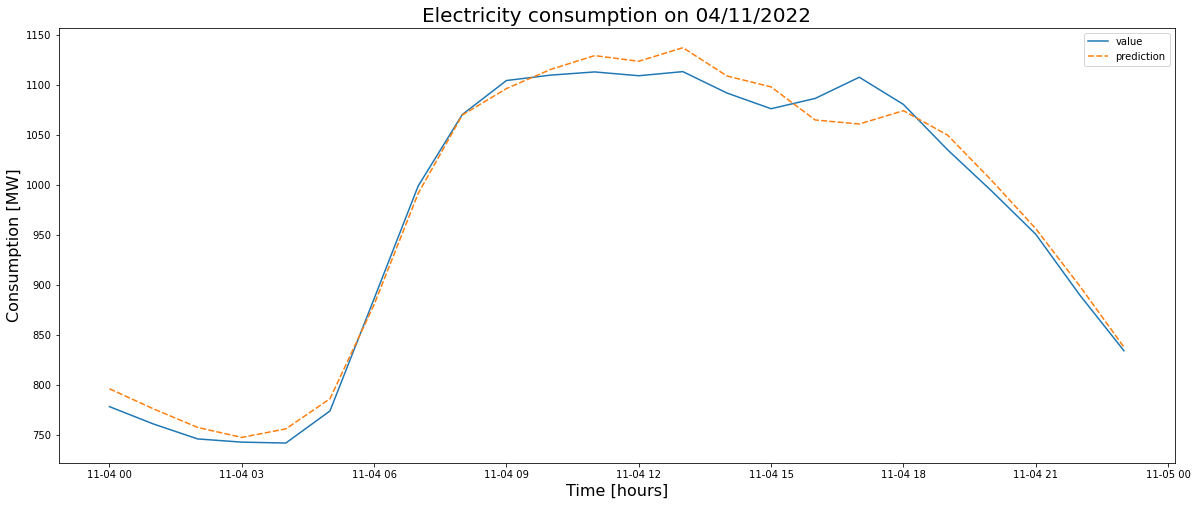

In [25]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

## Support Vector Machines (SVR)

MAPE: 1.161


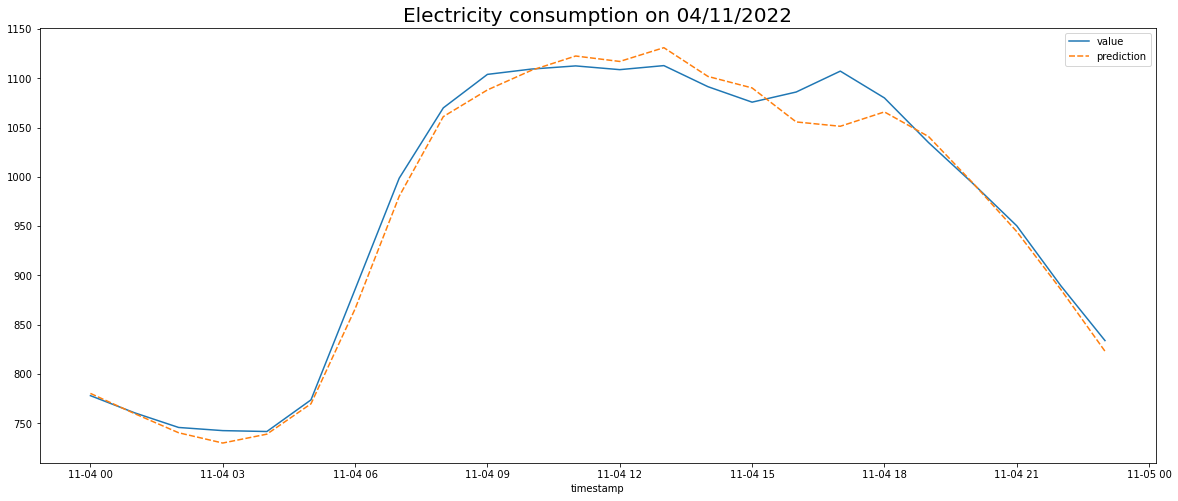

In [32]:
# Run several times

X_test = testing_vector[['lag7', 'lag2']]
y_test = testing_vector[['value']]

X_train = training_vector[['lag7', 'lag2']]
y_train = training_vector[['value']]

model = LinearSVR()
model.fit(X_train,y_train.values.ravel())

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

### Features: lag7, lag2, and temperature

In [27]:
X_test = testing_vector[['lag7', 'lag2', 'T']]
y_test = testing_vector[['value']]

X_train = training_vector[['lag7', 'lag2', 'T']]
y_train = training_vector[['value']]

## Linear model

MAPE: 2.338


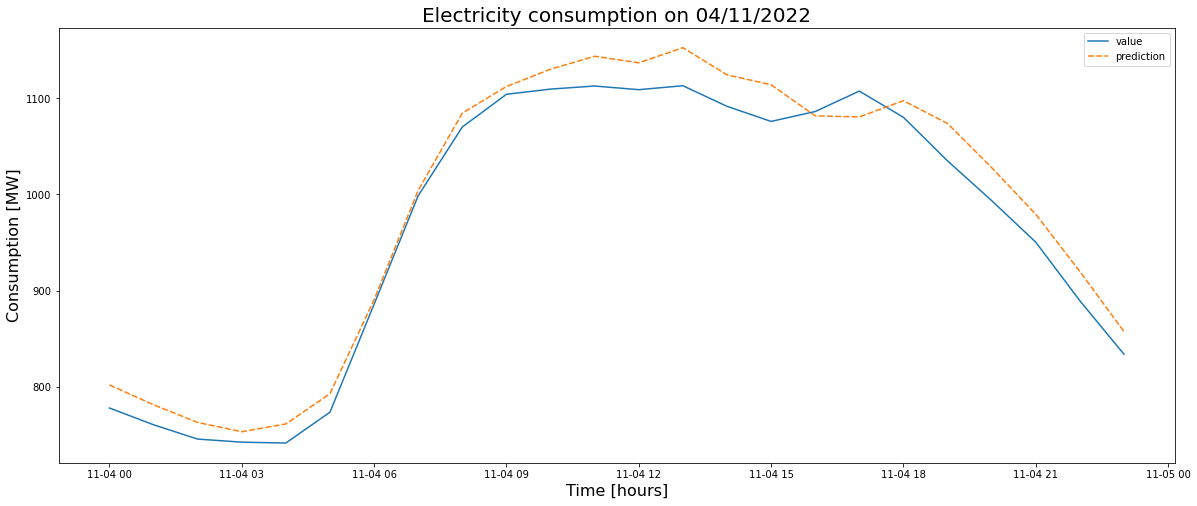

In [28]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

## SVR

MAPE: 1.218


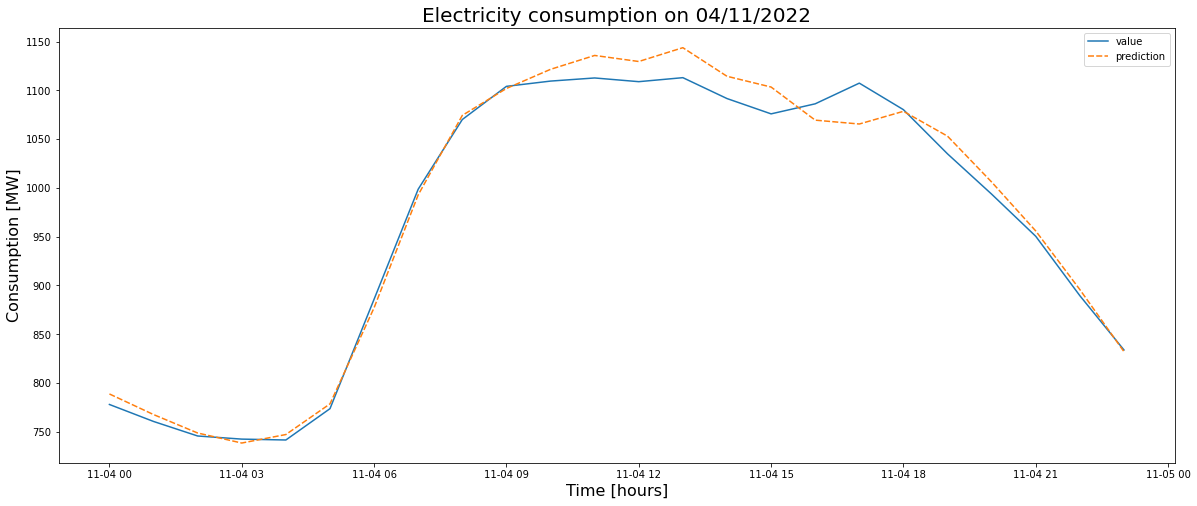

In [33]:
model = LinearSVR()
model.fit(X_train,y_train.values.ravel())

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Electricity consumption on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))